In [53]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.ndimage import rotate as sp_rotate

In [54]:
device = torch.device("cpu")

# Load data:

In [55]:
data = np.load('data/test_data_elemental_lines/XRF_sample1.npy')
print(data.shape)

(12, 30, 8)


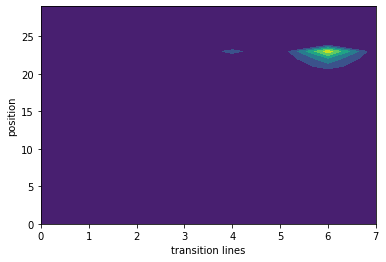

In [56]:
plt.contourf(data[0,:,:]) # Third angle:
plt.xlabel('transition lines')
plt.ylabel('position')
plt.show()

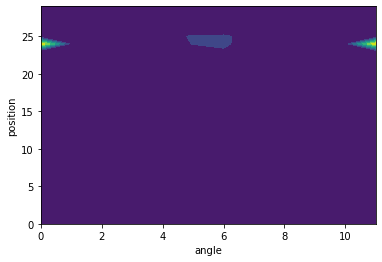

In [57]:
plt.contourf(data[:,:,3].transpose()) # Third angle:
plt.xlabel('angle')
plt.ylabel('position')
plt.show()

# Test how reshape works:

# Make mini-batch:

In [58]:
n_minibatch=5
minibatch_size = data[0].shape[0]//n_minibatch

# Take first angle:
angle = data[0]
print(angle.shape)

# Reshape
y = angle.reshape(n_minibatch, minibatch_size, -1)
y.shape

(30, 8)


(5, 6, 8)

# Inherit nn.Module to make our own model:

In [59]:
class PPM(nn.Module):
    def __init__(self, p):
        """
        Initialize the attributes of PPM. 
        """
        super(PPM, self).__init__() # inherit the __init__ from nn.Module.
        self.p = p  # indicate which minibatch to calculate the gradient  
        self.xp = self.init_xp() # initialize the values of the minibatch
        
    def init_xp(self):
        """
        Initialize self.x with 5x6x30 zero tensor. (n_minibatch x minibatch_dim0 x minibatch_dim1)
        """
        return nn.Parameter(torch.zeros(5, 6, 30))

        
    def forward(self, X, theta):  # convert X to y_hat; dimension changes from (5, 30, 30) to (30, 8)
        """
        Forward propagation.
        """
        
        X = sp_rotate(X.numpy(), theta, axes=(1, 2), reshape=False, order=1)
        X = torch.tensor(X)
        X[:, 6*self.p:6*(self.p+1), :] = self.xp
        X = torch.sum(X, axis=2)
        h1 =  torch.randn(30, 8)
        h2 =  torch.randn(30, 5)
        output = torch.matmul(h2, torch.matmul(X, h1))
        
        return output

In [60]:
a = torch.ones(2,2, requires_grad=True)
print(a)
a = a.detach().numpy()  #remove requires_grad and then converting to numpy array
print(a)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
[[1. 1.]
 [1. 1.]]


In [61]:
X = torch.randn(5, 30, 30)
X = torch.sum(X, axis =2)
print(X.shape)

h1 = torch.zeros(30, 8)
h = torch.matmul(X, h1)

h2 = torch.zeros(30, 5)
h = torch.matmul(h2, h)

print(h.shape)

torch.Size([5, 30])
torch.Size([30, 8])


In [62]:
X = torch.randn(5,30,30)
X_sum = torch.sum(X, dim = 2)
print(X_sum.shape)

m1 = torch.zeros(30, 5)
print(m1.shape)
m2 = torch.zeros(30, 8)
print(m2.shape)

print(torch.matmul(torch.matmul(m1, X_sum), m2).shape)

torch.Size([5, 30])
torch.Size([30, 5])
torch.Size([30, 8])
torch.Size([30, 8])


In [63]:
model = [PPM(m) for m in range(n_minibatch)]
theta_ls = - torch.linspace(0, 180, 12)

list(model[0].parameters())[0].shape

torch.Size([5, 6, 30])

In [67]:
# y_true = torch.tensor(angle)

y_true = torch.randn(30, 8)
# y_true = torch.randn(5, 30, 30)

X = torch.zeros(5, 30, 30)

loss_fn = nn.MSELoss()
optimizer = [torch.optim.Adam(model[m].parameters(), lr=0.01) for m in range(n_minibatch)]

for theta in theta_ls:    
    for m in range(n_minibatch): 
        y_hat = model[m](X, theta)
        loss = loss_fn(y_hat, y_true)
        optimizer[m].zero_grad()
        loss.backward()
        optimizer[m].step()
        print(y_hat)
        X[:, minibatch_size*m:minibatch_size*(m+1),:] = model[m].xp
        X = torch.tensor(X.detach().numpy())
    
    
# Check whether model.parameters() is model.x
#     print('Is model.parameters()= model.x?', list(model.parameters())[0] is model.x, '\n') # or print(list(model.parameters())[0] == model.x)
#     print('Print model.x', model.x, '\n')
#     print('Loss for angle {}: {}'.format(i, loss.item()) )

tensor([[ 9.9727e-04, -7.1973e-01,  8.2362e-01,  5.0964e-02,  2.2750e+00,
         -1.2239e+00,  6.3292e-01, -1.0217e+00],
        [ 5.1715e-01, -6.8574e-01,  1.7102e+00, -2.1079e+00,  2.2681e+00,
         -2.0152e+00,  1.3880e+00, -1.6569e+00],
        [ 4.4147e-01,  4.5273e-01, -5.1643e-01, -3.3525e-01, -2.5315e+00,
          1.2456e+00, -2.6049e-01,  1.5802e+00],
        [ 9.5506e-01,  3.2385e-01, -3.1801e-01,  1.4228e+00, -6.8561e-01,
          2.2474e-01,  5.0624e-01,  2.3298e+00],
        [-3.9086e-01,  1.5401e+00, -3.5676e-01,  6.5445e+00,  1.0966e+00,
          2.8265e-01,  1.3016e+00,  3.5925e+00],
        [ 4.3556e-01, -1.0480e+00,  4.5575e-01, -4.5402e+00, -7.3158e-01,
         -3.0690e-01, -6.0090e-01, -2.2396e+00],
        [-4.2343e-01, -6.0689e-01,  4.5957e-01, -7.3555e-01,  2.1463e+00,
         -1.1734e+00, -6.0925e-02, -2.1393e+00],
        [ 8.9231e-02,  7.0187e-01, -1.5230e+00, -1.8690e+00, -3.9800e+00,
          1.9375e+00, -1.7023e+00,  5.1519e-01],
        [-3.6269

torch.Size([30, 8])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0

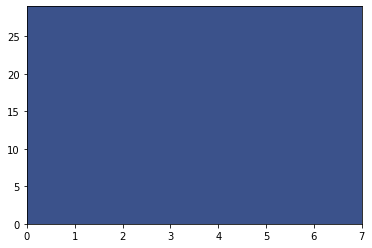

In [15]:
Y = model[0](X, theta_ls)
theta = -30
print(Y.shape)
plt.contourf(Y.detach().numpy()) # Remember to detach from the computational graph and convert to numpy in order
                                 # to make plot.
print(Y)
plt.show()